info at https://www.kaggle.com/datasets/openfoodfacts/world-food-facts

# Imports

In [2]:
import io
import shutil
import glob
import requests
from zipfile import ZipFile
from tempfile import mkdtemp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Lecture du dataset

In [3]:
def loadZipFromUrl(url: str):
    # Request zip on AWS
    print(f'load data from {url}')
    response = requests.get(url)

    # Unzip file
    tempDir = mkdtemp()
    print(f'extract to temp dir: {tempDir}')

    with ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(tempDir)

    csv = glob.glob(tempDir + '\*.csv')[0]

    # Read it in pandas
    print('Read csv by pandas')
    df = pd.read_csv(csv, delimiter='\t',
                     parse_dates=True,
                     low_memory=False)

    # Delete temp directory
    print('Delete temp Dir')
    shutil.rmtree(tempDir, ignore_errors=True)

    print('Dataset ready to explore under name: "df"!')
    return df

url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'    
df = loadZipFromUrl(url)
original = df.copy()

load data from https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip
extract to temp dir: C:\Users\Papoun\AppData\Local\Temp\tmpm6o9d5fy
Read csv by pandas
Delete temp Dir
Dataset ready to explore under name: "df"!


# Description rapide

Apperçu du dataset

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def printDataSetInfos(df: pd.DataFrame):
    memory_gb = np.round(df.memory_usage(deep=True).sum()/(1024**3),2)
    nb_lignes = df.shape[0]
    nb_columns = df.shape[1]
    print(f'A ce stade le dataset contient {nb_lignes} lignes et {nb_columns} colonnes. (conso mémoire {memory_gb}Gb)')
    
printDataSetInfos(df)

A ce stade le dataset contient 320772 lignes et 162 colonnes. (conso mémoire 1.72Gb)


# Nettoyage

### Suppression des colonnes inutiles

Je décide de supprimer les colonnes contenant des url et celles qui concernent les dates et createur

In [6]:
url_columns = df.columns[df.columns.str.contains('url')].to_list()
unused_columns = ['creator',
                  'created_t',
                  'created_datetime',
                  'last_modified_t',
                  'last_modified_datetime'
                 ]
df = df.drop(url_columns + unused_columns, axis=1)
printDataSetInfos(df)

A ce stade le dataset contient 320772 lignes et 154 colonnes. (conso mémoire 1.54Gb)


### Visualisation des taux de remplissage

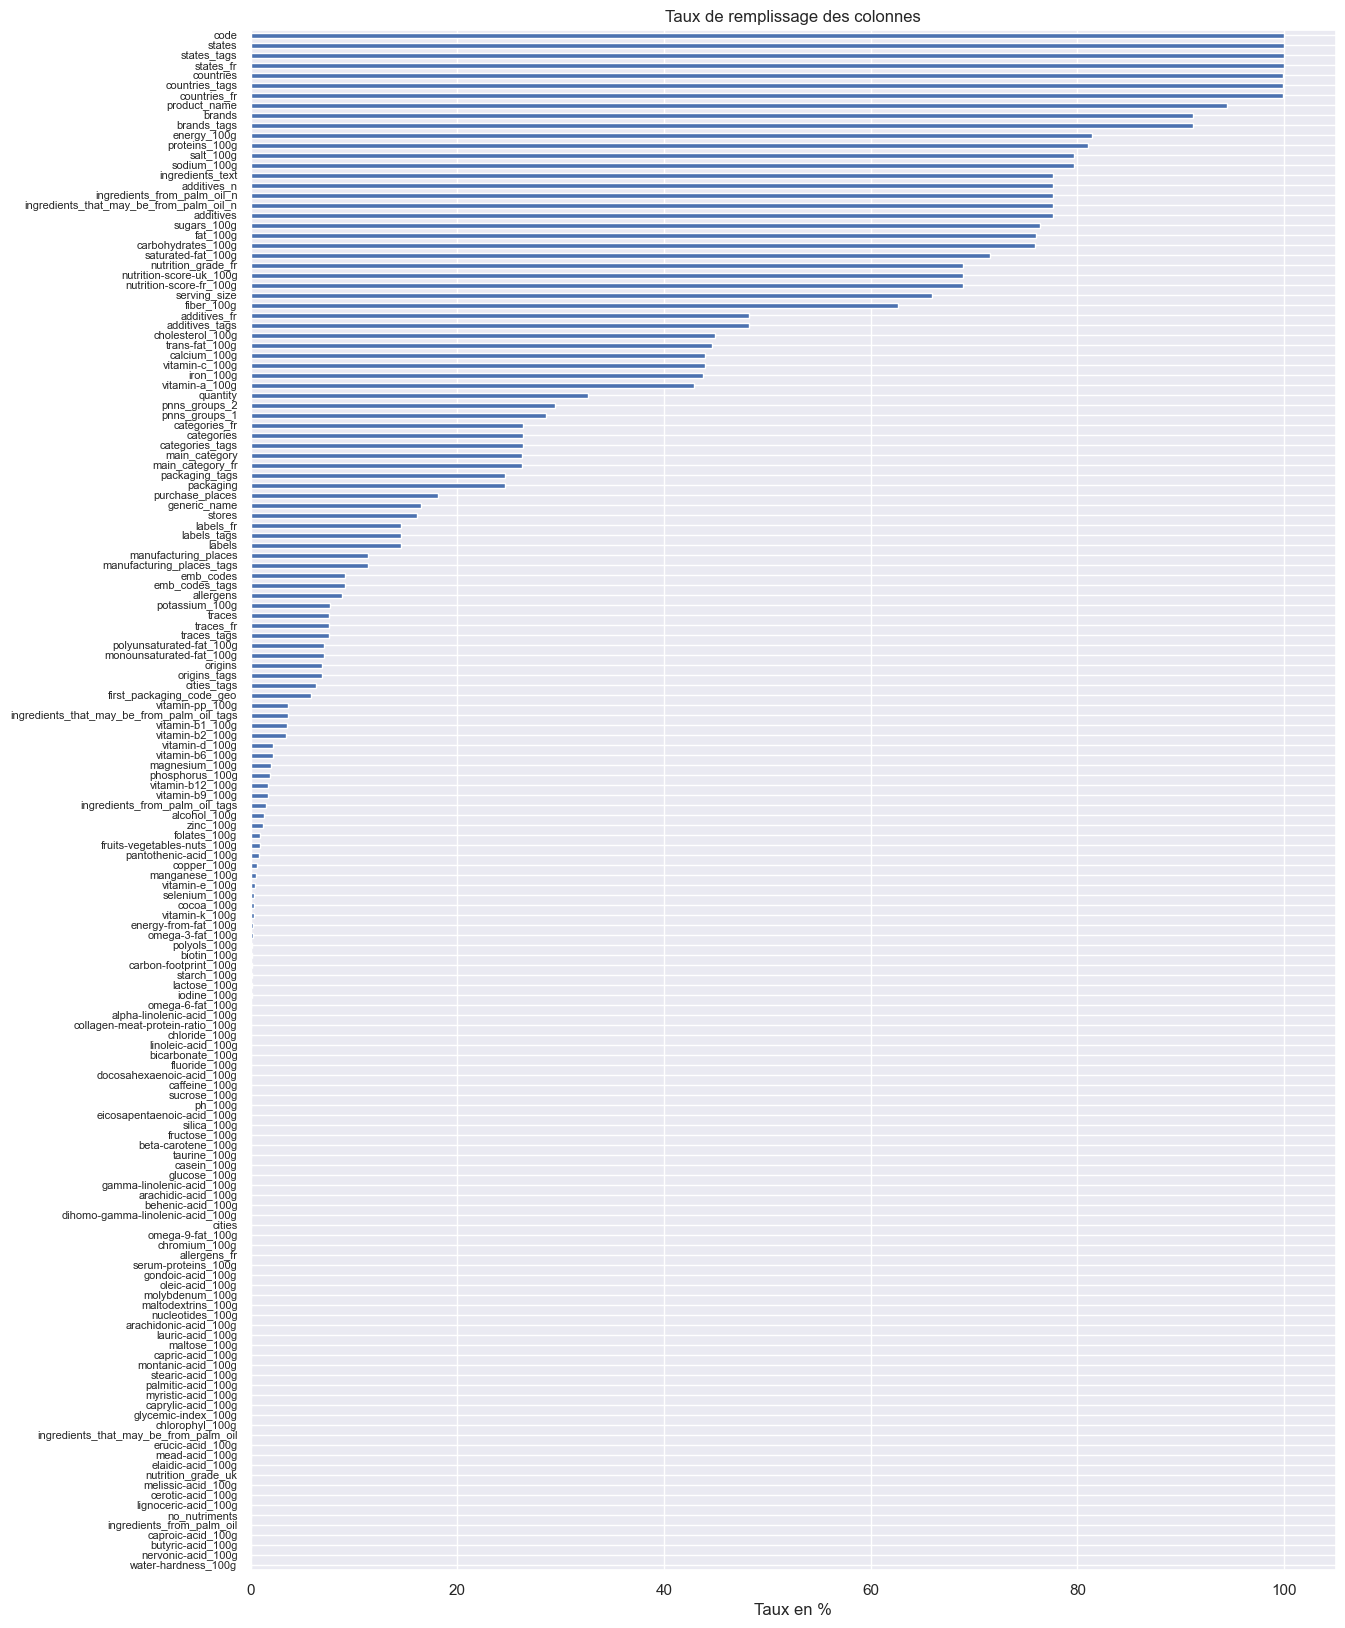

In [7]:
taux = (1 - df.isna().mean().sort_values(ascending=False))*100
figure = plt.figure(figsize=(14,20))
taux.plot.barh()
plt.yticks(fontsize=8)
plt.title('Taux de remplissage des colonnes')
plt.xlabel('Taux en %')
plt.show()

Des colonnes sont très vides. On va supprimer toutes les colonnes pour lesquelles le nombre de produits représentés est inférieur à 1000

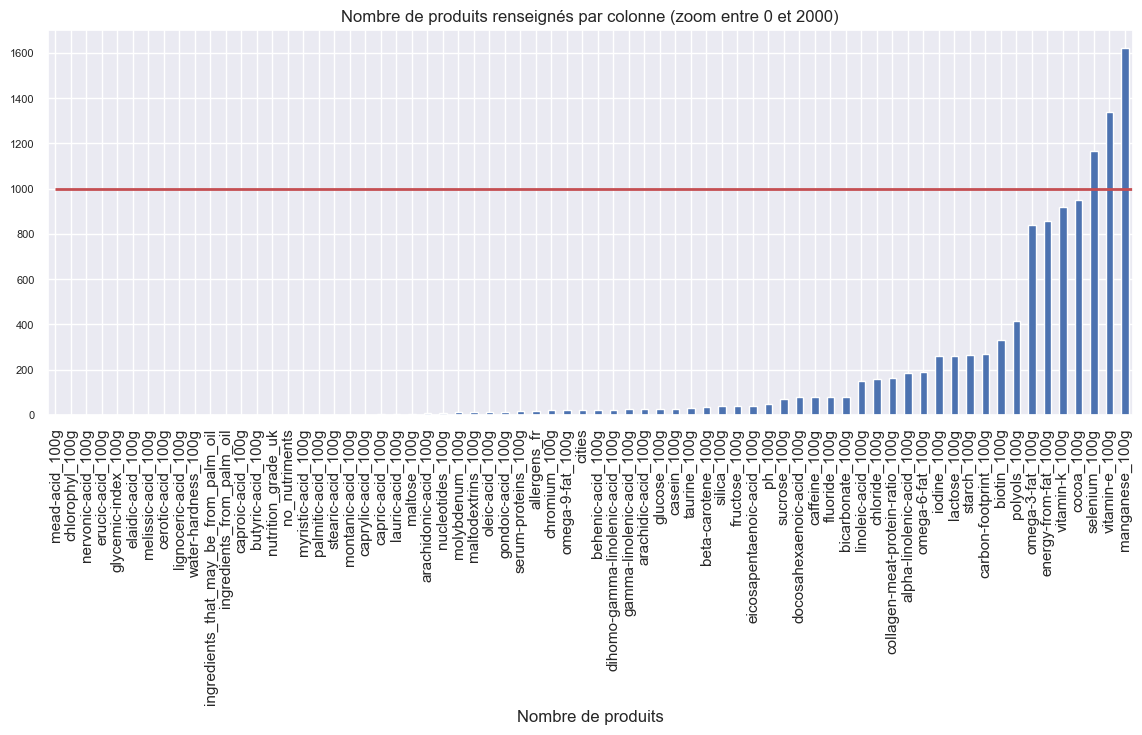

In [8]:
column_nb_values = len(df) - df.isna().sum()
figure = plt.figure(figsize=(14,5))
column_nb_values.loc[column_nb_values < 2000].sort_values().plot.bar()
plt.yticks(fontsize=8)
plt.title('Nombre de produits renseignés par colonne (zoom entre 0 et 2000)')
plt.xlabel('Nombre de produits')
plt.hlines(y=1000, xmin=0, xmax=100, colors='r', linewidths=2)
plt.show()

In [9]:
df = df.loc[:, column_nb_values > 1000]
printDataSetInfos(df)

A ce stade le dataset contient 320772 lignes et 87 colonnes. (conso mémoire 1.36Gb)


### Suppression des lignes ne contenant pas de code

In [10]:
df = df.loc[~df['code'].isna(), :]
printDataSetInfos(df)

A ce stade le dataset contient 320749 lignes et 87 colonnes. (conso mémoire 1.36Gb)


### Suppression des lignes ne contenant aucune information de nutrition
Les lignes qui ne contiennent aucune information de nutrition sont celles pour lesquelles aucune colonne _100g n'est remplie

In [11]:
nutrition_columns = df.columns[df.columns.str.endswith('_100g') & ~df.columns.str.contains('energy')]
empties_line_filter = df.loc[:, nutrition_columns].sum(axis=1) == 0
print(f'Nombre de lignes concernées: {len(df.loc[empties_line_filter,:])}')
df = df.loc[~empties_line_filter, :]
printDataSetInfos(df)

Nombre de lignes concernées: 59276
A ce stade le dataset contient 261473 lignes et 87 colonnes. (conso mémoire 1.17Gb)


 ### Suppression des lignes qui contiennent des valeurs de nutrition aberrantes (_100g < 0 ou _100g > 100)

In [12]:
df.loc[:, nutrition_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fat_100g,240709.0,12.898658,17.633115,0.000000,0.000000e+00,5.310000,20.540000,714.290000
saturated-fat_100g,228687.0,5.149381,8.023177,0.000000,0.000000e+00,1.800000,7.140000,550.000000
monounsaturated-fat_100g,22770.0,10.449321,17.088612,0.000000,0.000000e+00,4.000000,10.710000,557.140000
polyunsaturated-fat_100g,22802.0,6.328273,10.841518,0.000000,0.000000e+00,2.230000,7.300000,98.000000
trans-fat_100g,142625.0,0.073823,1.543844,-3.570000,0.000000e+00,0.000000,0.000000,369.000000
cholesterol_100g,143482.0,0.020156,0.358817,0.000000,0.000000e+00,0.000000,0.021000,95.238000
carbohydrates_100g,240424.0,32.496003,29.696740,0.000000,6.430000e+00,21.430000,59.000000,2916.670000
sugars_100g,242983.0,16.134338,22.371320,-17.860000,1.430000e+00,5.880000,24.240000,3520.000000
fiber_100g,200261.0,2.871001,12.886654,-6.700000,0.000000e+00,1.500000,3.600000,5380.000000
proteins_100g,256664.0,7.165670,8.424189,-800.000000,8.000000e-01,4.900000,10.000000,430.000000


In [13]:
# clean _100 < 0
negative_filter = (df.loc[:, nutrition_columns] < 0).sum(axis=1)
nb_negatives = len(df.loc[negative_filter > 0, :])
print(f'{nb_negatives} lignes contiennent une valeur nutritionnelle < 0')
df = df.loc[negative_filter == 0, :]

# clean _100 > 100
upper_100g = (df.loc[:, nutrition_columns] > 100).sum(axis=1)
nb_upper_100 = len(df.loc[upper_100g > 0, :])
print(f'{nb_upper_100} lignes contiennent une valeur nutritionnelle > 100')
df = df.loc[upper_100g == 0, :]

printDataSetInfos(df)

37372 lignes contiennent une valeur nutritionnelle < 0
207 lignes contiennent une valeur nutritionnelle > 100
A ce stade le dataset contient 223894 lignes et 87 colonnes. (conso mémoire 1.01Gb)


### Analyse des colonnes countries

In [14]:
countries_columns = df.columns[df.columns.str.contains('countries')]
countries_columns.to_list()

['countries', 'countries_tags', 'countries_fr']

In [15]:
df.loc[:, countries_columns]

,countries,countries_tags,countries_fr
1,US,en:united-states,États-Unis
2,US,en:united-states,États-Unis
3,US,en:united-states,États-Unis
4,US,en:united-states,États-Unis
5,US,en:united-states,États-Unis
...,...,...,...
320753,NaN,NaN,NaN
320756,en:CH,en:switzerland,Suisse
320757,France,en:france,France
320761,France,en:france,France


Les données semblent redondantes,on ne garde que la colonne countries_fr

In [16]:
df.drop(['countries', 'countries_tags'], axis=1, inplace=True)

In [17]:
df.loc[:, 'countries_fr'].dropna().unique()[:10]

array(['États-Unis', 'France,États-Unis', 'Canada', 'France', 'Allemagne',
       'Royaume-Uni', 'Espagne', 'France,Royaume-Uni',
       'Belgique,France,Pays-Bas,Royaume-Uni', 'Canada,États-Unis'],
      dtype=object)

<AxesSubplot:>

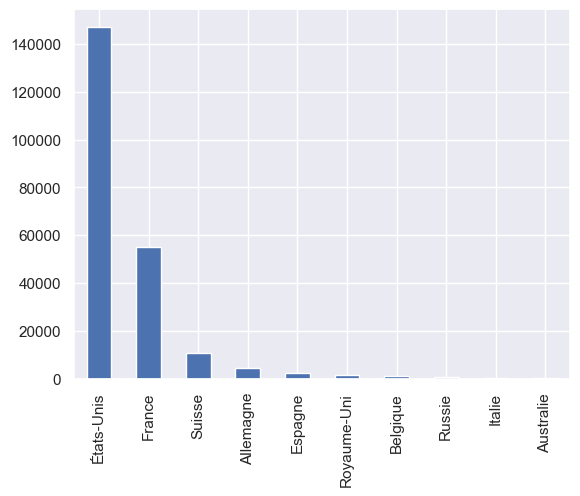

In [18]:
def extract_serie(dataFrame: pd.DataFrame, column: str) -> pd.Series:
    words = pd.Series(dtype=np.int32)
    for value in dataFrame.loc[:, column].dropna():
        splitted_values = value.split(',')
        for splitted_value in splitted_values:
            if splitted_value in words.keys():
                words[splitted_value] += 1
            else:
                words[splitted_value] = 0
    
    return words.sort_values(ascending=False)        
extract_serie(df, 'countries_fr')[0:10].plot.bar()

On constate que le jeu de données est un peu fouilli sur la déclaration des pays. 
<br>Voyons le nombre de produits représentés par pays (pour les 10 premiers)

### Analyse des colonnes categories

<AxesSubplot:>

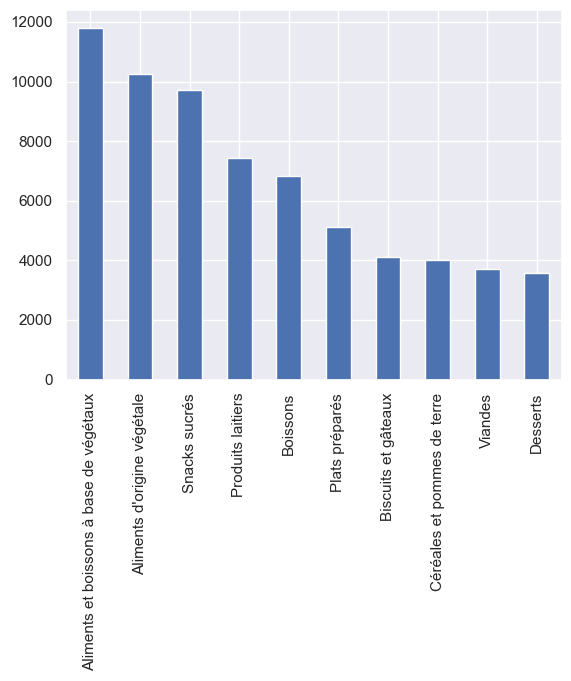

In [19]:
extract_serie(df, 'categories_fr')[0:10].plot.bar()

# Analyse des correlations

In [21]:
df.isna().mean().to_list()

[0.0,
 0.013738644179835101,
 0.83407326681376,
 0.7361340634407354,
 0.7719143880586349,
 0.7719143880586349,
 0.024140888098832483,
 0.024140888098832483,
 0.7575951119726299,
 0.7575951119726299,
 0.7575951119726299,
 0.9407889447685065,
 0.9408738063547929,
 0.8875851965662322,
 0.8875941293647887,
 0.8611217808427202,
 0.8608716624831393,
 0.8608716624831393,
 0.9077152581132143,
 0.9077197245124925,
 0.9401234512760502,
 0.9354694632281347,
 0.8238005484738313,
 0.8430462629637239,
 0.00029478235236317184,
 0.10519710220014829,
 0.897451472571842,
 0.9134635139842961,
 0.9134635139842961,
 0.9134635139842961,
 0.20536503881300971,
 0.10519710220014829,
 0.10528196378643465,
 0.39330218764236646,
 0.39330218764236646,
 0.10519710220014829,
 0.980026262427756,
 0.10519710220014829,
 0.9535092499129052,
 0.18285885285000938,
 0.7504756715231314,
 0.739720582061154,
 0.0,
 0.0,
 0.0,
 0.7575951119726299,
 0.7575951119726299,
 0.017235834814689092,
 0.08064977176699688,
 0.14589046602

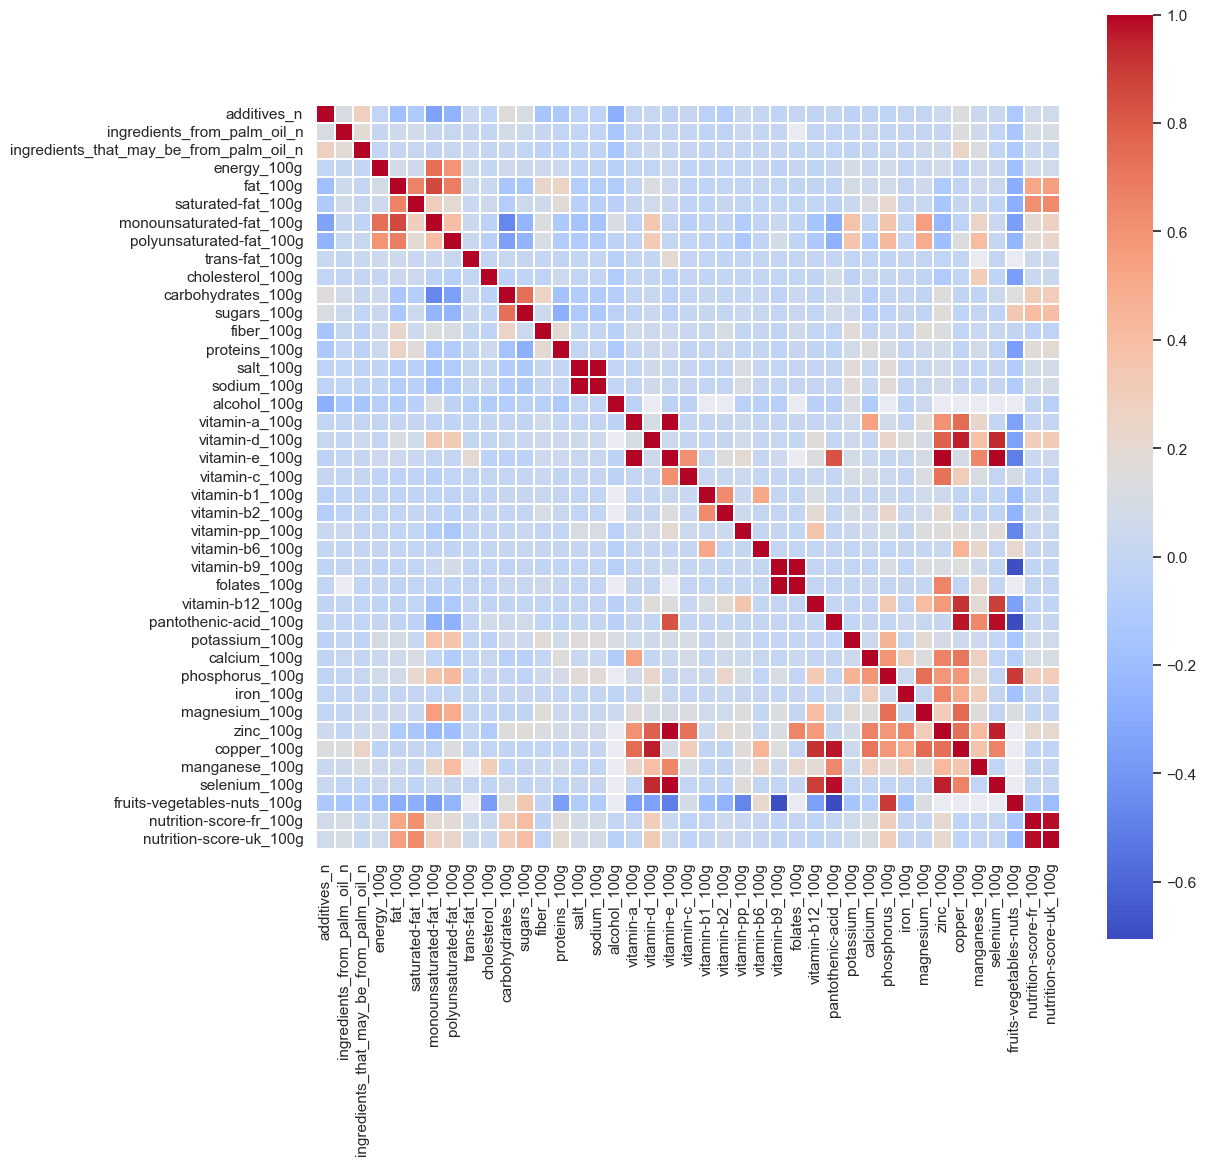

In [42]:
correlations = df.corr(numeric_only=True)
figure = plt.figure(figsize=(12,12))
sns.heatmap(correlations, square=True, linewidths=0.01, cmap="coolwarm")
plt.show()